# Clustering with scikit-learn

We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create 12 clusters our of them?

## Importing the Necessary Libraries

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import python_utils
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

In [2]:
data = pd.read_csv('./weather/minute_weather.csv')

## Description
The minute weather dataset contains raw sensor measurements captured at one-minute intervals.

The data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

Each row in **minute_weather.csv** contains weather data captured for a one-minute interval. Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [3]:
data.shape

(1587257, 13)

In [4]:
data.head()

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8


## Data Sampling
Lots of rows, so let us sample down by taking every 10th row.

In [5]:
sampled_df = data[(data['rowID'] % 10) == 0]
sampled_df.shape

(158726, 13)

## Statistics

In [6]:
sampled_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rowID,158726.0,793625.000000,458203.937509,0.00,396812.5,793625.00,1190437.50,1587250.00
air_pressure,158726.0,916.830161,3.051717,905.00,914.8,916.70,918.70,929.50
air_temp,158726.0,61.851589,11.833569,31.64,52.7,62.24,70.88,99.50
avg_wind_direction,158680.0,162.156100,95.278201,0.00,62.0,182.00,217.00,359.00
avg_wind_speed,158680.0,2.775215,2.057624,0.00,1.3,2.20,3.80,31.90
max_wind_direction,158680.0,163.462144,92.452139,0.00,68.0,187.00,223.00,359.00
max_wind_speed,158680.0,3.400558,2.418802,0.10,1.6,2.70,4.60,36.00
min_wind_direction,158680.0,166.774017,97.441109,0.00,76.0,180.00,212.00,359.00
min_wind_speed,158680.0,2.134664,1.742113,0.00,0.8,1.60,3.00,31.60
rain_accumulation,158725.0,0.000318,0.011236,0.00,0.0,0.00,0.00,3.12


In [7]:
sampled_df[sampled_df['rain_accumulation'] == 0].shape

(157812, 13)

In [8]:
sampled_df[sampled_df['rain_duration'] == 0].shape

(157237, 13)

## Drop all the Rows with Empty rain_duration and rain_accumulation

In [9]:
del sampled_df['rain_accumulation']
del sampled_df['rain_duration']

In [10]:
rows_before = sampled_df.shape[0]
sampled_df = sampled_df.dropna()
rows_after = sampled_df.shape[0]

<p style="font-family: Arial; font-size:1.75em;color:purple; font-style:bold"><br>

How many rows did we drop ?
<br><br></p>


In [11]:
rows_before - rows_after

46

In [12]:
sampled_df.columns

Index(['rowID', 'hpwren_timestamp', 'air_pressure', 'air_temp',
       'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction',
       'max_wind_speed', 'min_wind_direction', 'min_wind_speed',
       'relative_humidity'],
      dtype='object')

## Select Features of Interest for Clustering


In [13]:
features = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']

In [14]:
select_df = sampled_df[features]

In [15]:
select_df.columns

Index(['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed',
       'max_wind_direction', 'max_wind_speed', 'relative_humidity'],
      dtype='object')

In [26]:
select_df.head()

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity
0,912.3,64.76,97.0,1.2,106.0,1.6,60.5
10,912.3,62.24,144.0,1.2,167.0,1.8,38.5
20,912.2,63.32,100.0,2.0,122.0,2.5,58.3
30,912.2,62.60,91.0,2.0,103.0,2.4,57.9
40,912.2,64.04,81.0,2.6,88.0,2.9,57.4


## Scale the Features using StandardScaler

In [17]:
X = StandardScaler().fit_transform(select_df)
X

array([[-1.48456281,  0.24544455, -0.68385323, ..., -0.62153592,
        -0.74440309,  0.49233835],
       [-1.48456281,  0.03247142, -0.19055941, ...,  0.03826701,
        -0.66171726, -0.34710804],
       [-1.51733167,  0.12374562, -0.65236639, ..., -0.44847286,
        -0.37231683,  0.40839371],
       ...,
       [-0.30488381,  1.15818654,  1.90856325, ...,  2.0393087 ,
        -0.70306017,  0.01538018],
       [-0.30488381,  1.12776181,  2.06599745, ..., -1.67073075,
        -0.74440309, -0.04948614],
       [-0.30488381,  1.09733708, -1.63895404, ..., -1.55174989,
        -0.62037434, -0.05711747]])

## Use k-Means Clustering

In [35]:
kmeans = KMeans(n_clusters=12)
model = kmeans.fit(X)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## What are the centers of 12 clusters we formed ?

In [28]:
centers = model.cluster_centers_
centers

array([[-0.16444756,  0.86394199, -1.31093042, -0.58976792, -1.16664184,
        -0.60507791, -0.64070558],
       [-0.84029005, -1.19800987,  0.37503227,  0.35287586,  0.47351963,
         0.34083458,  1.36262479],
       [ 1.36640063, -0.08086732, -1.20745822, -0.0513879 , -1.07623433,
        -0.03116097, -0.977592  ],
       [ 1.19010134, -0.2544877 , -1.15492416,  2.12206287, -1.05342976,
         2.23876646, -1.13464887],
       [ 0.06070376, -0.78846084, -1.19694723, -0.57087769, -1.04291764,
        -0.58540237,  0.87817326],
       [ 0.73213999,  0.43365769,  0.28574442, -0.53378268,  0.47341398,
        -0.54001986, -0.77244424],
       [ 0.25364706, -0.9942776 ,  0.66011853, -0.54752773,  0.85137519,
        -0.53011159,  1.15758435],
       [-1.17892331, -0.87705307,  0.4464358 ,  1.97572344,  0.53847429,
         1.93711224,  0.91527221],
       [ 0.23378992,  0.3194701 ,  1.88794624, -0.65194259, -1.55164204,
        -0.57678283, -0.28275652],
       [-0.69441212,  0.5457

## Plots

Let us first create some utility functions which will help us in plotting graphs:

In [20]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')
    
	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas data frame for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

In [21]:
# Function that creates Parallel Plots

def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [22]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,0.233585,0.319087,1.887854,-0.651989,-1.551707,-0.576833,-0.282716,0
1,-0.690243,0.552341,0.179313,-0.584561,0.349124,-0.597936,-0.119811,1
2,-0.162115,0.863302,-1.310696,-0.589992,-1.166274,-0.605244,-0.642466,2
3,-1.181083,-0.874309,0.447045,1.979614,0.538956,1.940919,0.912273,3
4,0.247241,-0.994311,0.658827,-0.547495,0.849971,-0.530208,1.160149,4
5,-0.212480,0.631057,0.408472,0.735941,0.516543,0.673776,-0.149628,5
6,0.737410,0.424804,0.286169,-0.531345,0.473569,-0.537638,-0.772142,6
7,0.057915,-0.786073,-1.196163,-0.571038,-1.042140,-0.585591,0.876802,7
8,1.368270,-0.082093,-1.207181,-0.047318,-1.076190,-0.026926,-0.977590,8
9,0.132385,0.844301,1.410748,-0.638706,1.674789,-0.589429,-0.714220,9


## Dry Days

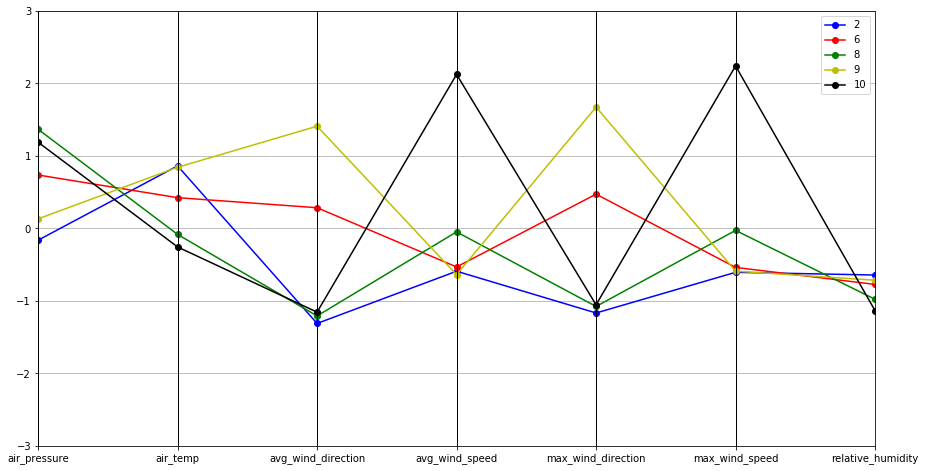

In [31]:
parallel_plot(P[P['relative_humidity'] < -0.5])

## Warm Days

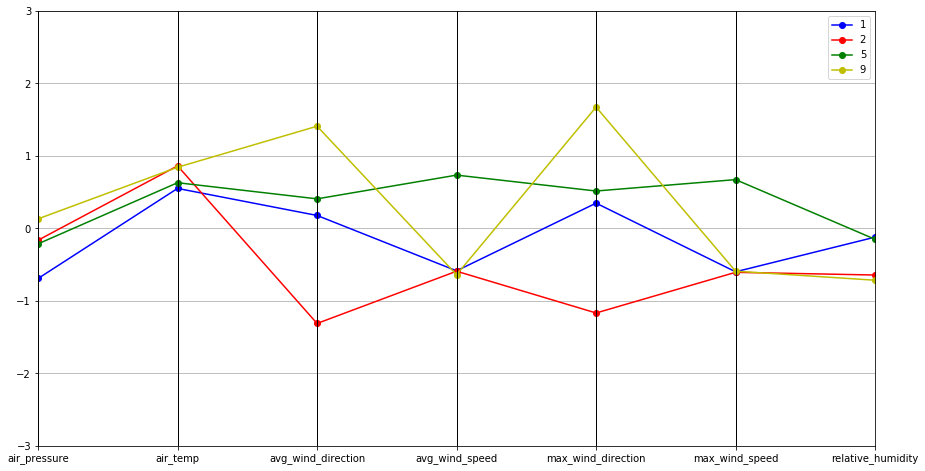

In [32]:
parallel_plot(P[P['air_temp'] > 0.5])

## Cool Days

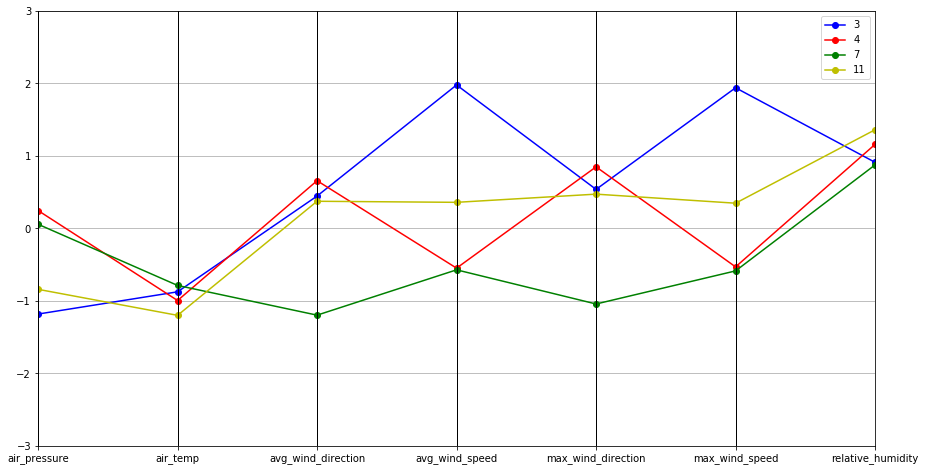

In [33]:
parallel_plot(P[(P['relative_humidity'] > 0.5) & (P['air_temp'] < 0.5)])

They're close to each other for a few features, and far apart on others. If they differ on a particular feature, this is one of the features which is likely helpful to distinguish this cluster from others.